In [29]:
# import necessary libraries
import re, string, unicodedata
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier


#Balanceo de clases y variables
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA


SEED=42

In [30]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

In [31]:
# cargar los datos
df_original = pd.read_csv('data/tipo1_entrenamiento_estudiantes.csv')

# Entendimiento

In [32]:
df_original.shape

(7875, 2)

In [33]:
df_original.sample(5)

,Review,Class
7445,"Hay callejones igual de lindos por toda la ciudad, antes estaba bonito porque no había tanta gente, ahora no se puede pasar, creo que es una pérdida de tiempo, a menos que tengas que pasar por ahí, pero ir a eso únicamente no creo que vale la pena.",2
2797,"Habitación grande y limpia. En particular me gustó el hecho de que el aire acondicionado era una temperatura moderada, no a todo volumen aire frío. Como leí en otro comentario, la mañana de marcharnos, nos despertamos con el agua caliente de potencia se apaga en nuestra habitación. Tuve que llamar para volver (que ocurrió inmediatamente después de que se llama - Magic! ). Creo que esto era debido al hecho de que nos falló en leer la cuenta de la salida que pide a instalarse en los extras en la noche antes de la salida, no el día de. Además, como he leído en otro comentario, el servicio de la limpieza llamó, luego especificada (a pesar de un cartel de No molestar en la puerta). dejaron una vez que se dieron cuenta que mi novio estaba en el jacuzzi y yo estaba en la ducha, pero realmente?! Nos encantó el jacuzzi en la habitación, pero los chorros no funcionaban hasta que se llama alguien que viene arreglar. Me encantaron los dispensadores de bebidas alcohólicas.\n\nPiscina - agua turbia me hizo no quieres ir hasta después de un par de copas. Hubiera preferido tener una piscina designada como para adultos. Piscina cierra a las 10 pm. Creo que la próxima vez me alojaré en un sólo para adultos todo incluido para tener acceso a la piscina después de horas.\n\nPlaya - agua estaba turbia (quizás de tormentas), muy cálida y tranquila y sin olas. Arena era agradable. Era una playa normal.\n\n- Excelente servicio de atención al cliente servicio de atención al cliente, todo el personal era muy amable y servicial.\n\nTransporte a/desde el aeropuerto, en el camino hacia el hotel, sólo nos pusieron en un taxi. Aunque se aseguraron que tiene aire acondicionado, pero un poco me sentí como que podría haber aclamada mi propio taxi. El taxista fue excelente, así que le dimos él extra. En el camino hacia el aeropuerto, nos fuimos en un transporte con otra familia. Esto es lo que me esperaba por el precio.\n\nEspectáculos - gratamente sorprendido que éstas eran muy entretenido (espectáculo de fuego y espectáculo folklórico mexicano).\n\nComida - estoy mimado porque vivo en California y regularmente tienen acceso a una excelente comida. Cada cosa era - complejo 'buena comida'. Me pareció que el mejor lugar era Frida (mexicano). También me pareció que sería difícil italiano mess up. Y yo estaba equivocado, la lasaña helada del complejo turístico Stouffer es mejor que esto! La pizza junto a la piscina y el servicio de habitación es tan práctico.\n\nExcursiones (complejo Créditos) - no nos aventura con delfines, lo cual fue divertido y muy cercanos. No tome demasiado tiempo, pero comprar fotos era exageradamente caro.\nTambién hicimos el Indio Zipline tour. Es 1,5 horas en un autobús al aire libre, lo que le da un buen recorrido de Puerto Vallarta y costa, pero es un poco de miedo. También tuvimos que cumplan con este autobús en una tienda de conveniencia de OXXO, y un taxi desde el hotel nos llevó a una equivocada (me sentí el botones deberían confirmarse con él la ubicación antes de que nos fuimos, y yo incluso señaló a la ubicación correcta, así que quizás este conductor de taxi sólo quería tornillo). Terminamos oriundo otro taxi e ir a la ubicación correcta, pero casi perdemos el viaje. Las las tirolinas fueron muy divertidos, traer insecticida, la degustación de tequila después estaba bien, pero la comida era demasiado caro y no es bueno. No te permiten llevar su cámara, pero por suerte las fotos aquí eran más razonable que la aventura con delfines.",3
1937,"Fui sola, a la llegada encontre 3 meseros charle que charle en la puerta (maluco eso) me asignaron una mesa lejos y escondida y el restaurante no tenia sino una mesa ocupada, casi no me reciben el pedido y los meseros co

In [34]:
df_original.isnull().sum()

Review    0
Class     0
dtype: int64

No hay registros nulos, los datos son completos.

<Axes: xlabel='Class'>

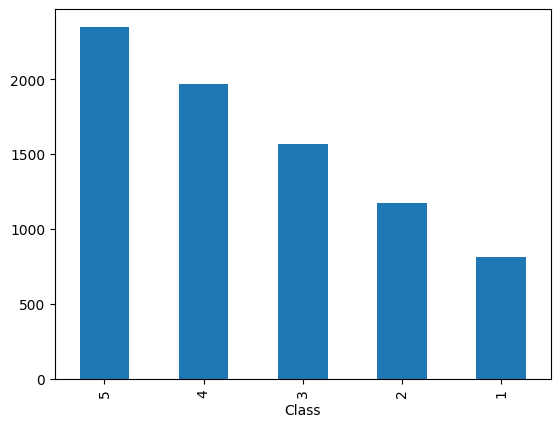

In [35]:
# distribución de variable objetivo
df_original['Class'].value_counts().plot(kind='bar')

Todos los valores de la columna 'Class' son válidos.

In [36]:
df_original.duplicated().sum()

71

Hay 71 registro duplicados, estos se deben eliminar del dataset.

In [37]:
duplicated_rows = df_original[df_original.duplicated()]
duplicated_rows


,Review,Class
518,"La ubicación es muy buena, al igual que la vista, la playa contrario a lo que esperaba resultó que estaba bastante limpia.\nSe percibe el sabor y la frescura en los insumos de los alimentos , lo cual es parte de la experiencia que ofrece...el lugar ya que tienen sus propias granjas productoras. La carta es limitada ( lo cual en mi caso prefiero, ya que se nota el esmero en cada uno de los platos que preparan), los precios están por arriba del promedio de otros restaurantes cercanos pero no llegan a ser exagerados, desconozco si eso se debió a que solo se tenía un salón disponible, ya que en la fecha que lo visité, el resto del restaurante se encontraba en remodelación (es la único razón por lo cual no otorgo la evaluación más alta), mi sugerencia sería que siguieran manteniendo los precios ya que los hace muy competitivos … sin duda regresaría, es un lugar que debes visitar en Veracruz sobre todo si eres fanático del buen comer…Más",4
1112,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
1605,"Cierran a las 3 pm, cobraron $85 adultos y niños (por lo menos los de 2 años) y adulto mayor gratis. A la entrada hay guías. Se juntan grupos de mínimo 10 personas y te cobran $70 por persona o $700 a quien se los pague. Excelente explicación y atención de parte de ellos. Poca claridad de información en redes, y el número telefónico no sirve. Llegamos fácilmente con waze. Lleven buen bloqueador, sombrero y de preferencia tenis.",3
1843,"Acudimos un sábado 2 de julio a las 11:15 de la mañana. Estuvimos esperando más de media hora nosotros dos y otro grupo de cuatro personas fuera, porque la camarera estaba dentro. Nos vio como estábamos esperando y no fue capaz de salir a atendernos...o dar alguna explicación si el bar estaba abierto o cerrado.\n\nNos tuvimos que marcharMás",1
1851,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
...,...,...
7520,"Un lugar muy limpio ordenado hermoso con áreas amplias que vale la pena disfrutar en familia un momento, primera vez que lo visito pero vale la pena acudir.",3
7601,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
7756,Deben de actualizar los horarios en las diferentes páginas ya que como yo o cualquiera de los visitantes que vamos podemos llegar y encontrar cerrado y luego la página para buscar información no funciona.,3
7794,"Wow Había escuchado muchas recomendaciones de este lugar, pero nunca había ido, hace unos fui y me precio muy interesante toda las historias que hay en este museo.",5


# Procesamiento y Preparación

In [38]:
# eliminar las filas duplicadas
df_prep = df_original.drop_duplicates()

In [39]:
df_prep.shape

(7804, 2)

## Divisón en entrenamiento y prueba 

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df_prep["Review"], df_prep["Class"], test_size = 0.2, stratify = df_prep["Class"], random_state = SEED)

In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6243,), (1561,), (6243,), (1561,))

## Tokenización / Vectorización

"Feature engineering"

* Bag of Words / Count Tokenizer
* Tf-IDF

In [42]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [43]:
# Descargar los datos necesarios
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andresarevalo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andresarevalo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [44]:
stop_words = set(stopwords.words('spanish'))

In [45]:
def tokenize_text(text):
    # convertir a minúsculas
    text = text.lower()
    
    # eliminar caracteres numericos
    text = re.sub(r'\d+', '', text) 

    # eliminar puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # eliminar caracters especiales
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons TODO: not all emojis included here
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               "]+", flags=re.UNICODE)
    
    text = emoji_pattern.sub(r'', text)

    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')  
     
    tokens = word_tokenize(text)

    # eliminar los stems de las palabras
    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(t) for t in tokens]
    return tokens

In [46]:
bow_vectorizer = CountVectorizer(stop_words=list(stop_words), lowercase=True, tokenizer=tokenize_text)
tfidf_vectorizer = TfidfVectorizer( stop_words=list(stop_words), lowercase=True, tokenizer=tokenize_text)

In [47]:
X_train_bow = bow_vectorizer.fit_transform(X_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estareis', 'estari', 'estariais', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'estuvier', 'estuvies', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habeis', 'habi', 'habiais', 'habr', 'habreis', 'habri', 'habriais', 'hast', 'hayais', 'hem', 'hub', 'hubier', 'hubies', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'sereis', 's

In [48]:
len(bow_vectorizer.vocabulary_)

13491

In [49]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [50]:
len(tfidf_vectorizer.vocabulary_)

13491

In [ ]:
df_bow_sklearn = pd.DataFrame(X_train_bow.toarray(),columns=bow_vectorizer.get_feature_names_out())
df_bow_sklearn

In [55]:
#FRECUENCIA DE PALABRAS

# Obtener el vocabulario
vocabulario = bow_vectorizer.vocabulary_
# Obtener la suma de las frecuencias de cada palabra en todo el conjunto de datos
frecuencia_total = X_train_bow.sum(axis=0)
# Crear un diccionario que mapea cada palabra a su frecuencia total
frecuencias = {palabra: frecuencia_total[0, indice] for palabra, indice in vocabulario.items()}

# Convertir el diccionario de frecuencias en un DataFrame
df_frecuencias = pd.DataFrame(list(frecuencias.items()), columns=['Palabra', 'Frecuencia'])

# Ordenar el DataFrame por frecuencia de forma descendente
df_frecuencias = df_frecuencias.sort_values(by='Frecuencia', ascending=False)
# Imprimir las frecuencias de cada palabra
df_frecuencias

,Palabra,Frecuencia
4,par,5098
81,com,4167
92,hotel,3236
167,per,3139
126,buen,2831
...,...,...
7710,salient,1
7706,armabl,1
7703,profir,1
7701,recurrent,1


In [67]:
df_palabras_altafrec = df_frecuencias[df_frecuencias['Frecuencia'] > 50]
df_palabras_altafrec.describe()

,Frecuencia
count,800.000000
mean,242.613750
std,395.742865
min,51.000000
25%,75.000000
50%,123.000000
75%,266.500000
max,5098.000000


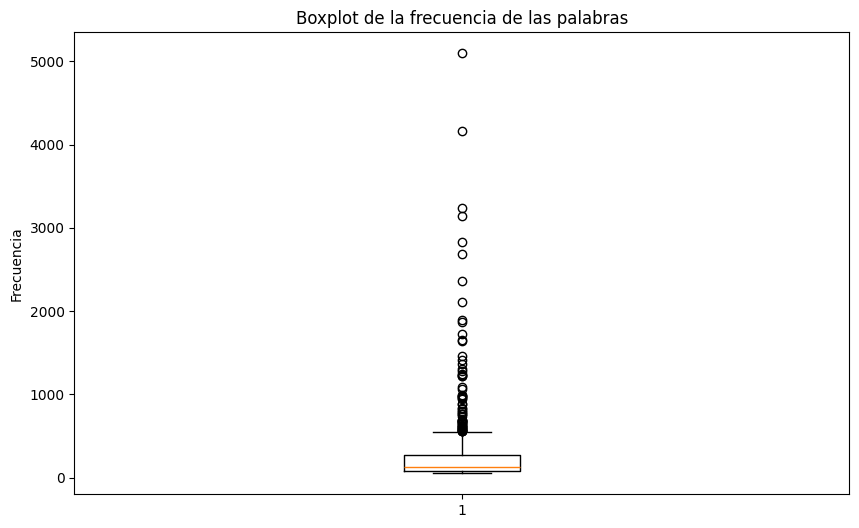

In [68]:
#Box plot
plt.figure(figsize=(10, 6))
plt.boxplot(df_palabras_altafrec['Frecuencia'])
plt.title('Boxplot de la frecuencia de las palabras')
plt.ylabel('Frecuencia')
plt.show()

In [76]:
# Obtener las palabras de alta frecuencia como una lista
palabras_altafrecuencia = df_palabras_altafrec['Palabra'].tolist()

# Filtrar las columnas que coinciden con las palabras de alta frecuencia
df_bow_sklearn_filtrado = df_bow_sklearn[palabras_altafrecuencia]

len(df_bow_sklearn_filtrado.columns)

800

In [78]:
# Convertir el DataFrame de nuevo a un array de NumPy
X_train_bow = df_bow_sklearn_filtrado.to_numpy()
X_train_bow.shape

(6243, 800)

# Entrenamiento y evaluación de modelos

## Random Forest

Desarrollado por: Andrés Arévalo

[descripción]

Balanceo de Clases

In [ ]:
# Instanciar el objeto SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE para balancear las clases
X_resampled_train_bow, y_resampled_train_bow = smote.fit_resample(X_train_bow, y_train)

#Y como df y histograma
y_resampled_train_bow_df = pd.DataFrame(y_resampled_train_bow, columns=['Class'])
y_resampled_train_bow_df['Class'].value_counts().plot(kind='bar')


In [79]:
X_test_bow = bow_vectorizer.transform(X_test)
# Convertir la matriz dispersa X_test_bow a un DataFrame
df_X_test_bow = pd.DataFrame(X_test_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())

# Filtrar las columnas que coinciden con las palabras de alta frecuencia
df_X_test_bow_filtrado = df_X_test_bow[palabras_altafrecuencia]
print(len(df_X_test_bow_filtrado.columns))
# Convertir el DataFrame de nuevo a un array de NumPy
X_test_bow = df_X_test_bow_filtrado.to_numpy()


800


In [ ]:
# Número máximo de componentes principales permitidos
max_components = min(X_train_bow.shape[0], X_train_bow.shape[1])

# Instanciar el objeto PCA con el número máximo de componentes permitidos
pca = PCA(n_components=2000, svd_solver='arpack')

# Aplicar PCA a X_train_bow
X_train_pca = pca.fit_transform(X_train_bow)

# Calcula la varianza explicada acumulada
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Grafica el gráfico de Pareto cada 200 componentes
componentes = np.arange(1, len(cumulative_variance_ratio) + 1)
cada_200_componentes = range(1,2000)
plt.plot(componentes, cumulative_variance_ratio, marker='o', linestyle='-')
plt.xticks(cada_200_componentes)
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.title('Gráfico de Pareto de Varianza Explicada Acumulada')
plt.grid(True)
plt.show()


In [ ]:
# Crear el clasificador de Random Forest
random_forest = RandomForestClassifier(n_estimators=200, random_state=42)

# Entrenar el modelo utilizando X_train_bow como matriz de características y y_train como vector de etiquetas
random_forest.fit(X_resampled_train_bow, y_resampled_train_bow)

In [80]:
# Crear el clasificador de Random Forest
random_forest = RandomForestClassifier(n_estimators=50, random_state=42)

# Entrenar el modelo utilizando X_train_bow como matriz de características y y_train como vector de etiquetas
random_forest.fit(X_train_bow, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [81]:
from sklearn.metrics import classification_report

y_pred = random_forest.predict(X_test_bow)
# Obtener el informe de clasificación
report = classification_report(y_test, y_pred)

# Imprimir el informe de clasificación
print(report)


              precision    recall  f1-score   support

           1       0.41      0.18      0.25       158
           2       0.37      0.32      0.34       232
           3       0.34      0.34      0.34       310
           4       0.38      0.35      0.36       393
           5       0.56      0.73      0.64       468

    accuracy                           0.44      1561
   macro avg       0.41      0.39      0.39      1561
weighted avg       0.43      0.44      0.43      1561



### Conclusiones

## [nombre algoritmo]

Desarrollado por:

[descripción]

### Conclusiones

## [nombre algoritmo]

Desarrollado por:

[descripción]

### Conclusiones

## Selección de final